In [1]:
# Pennylane modules
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Sampler

In [3]:
from qiskit.circuit.library import QFT
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2

from qiskit import transpile, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.dagcircuit import DAGCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino

# transpiler passes
from qiskit.transpiler.passes.layout import csp_layout, dense_layout, sabre_layout, vf2_layout, trivial_layout
# Routing pa″sses
from qiskit.transpiler.passes.routing import basic_swap, lookahead_swap, sabre_swap
from qiskit.transpiler.passes.routing import star_prerouting
# Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis import basis_translator
from qiskit.transpiler.passes.synthesis import unitary_synthesis, high_level_synthesis
# Optimization passes
from qiskit.transpiler.passes.optimization import commutative_cancellation, consolidate_blocks, collect_2q_blocks, collect_1q_runs

In [4]:
from pennylane.optimize import QNGOptimizer

In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report, log_loss
)

# Data Import

In [6]:
IEEE_train = pd.read_csv("/Users/soardr/VSCode Projects/Zenqor/data/IEEE-CIS/train_data.csv")
IEEE_test = pd.read_csv("/Users/soardr/VSCode Projects/Zenqor/data/IEEE-CIS/test_data.csv")

In [7]:
NSLKDD_train = pd.read_csv("/Users/soardr/VSCode Projects/Zenqor/data/NSL-KDD/Train.csv")
NSLKDD_test = pd.read_csv("/Users/soardr/VSCode Projects/Zenqor/data/NSL-KDD/Test.csv")

In [8]:
SECOM = pd.read_csv("/Users/soardr/VSCode Projects/Zenqor/data/uci-secom/uci-secom.csv")
SECOM.shape

(1567, 592)

In [9]:
SECOM

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1


In [10]:
secom_feats = [str(i) for i in range(199, 211, 1)]
secom_feats.append('Pass/Fail')

In [11]:
SECOM = SECOM[secom_feats]

In [12]:
SECOM.dropna(inplace=True)

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2461088957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SECOM.dropna(inplace=True)


In [13]:
SECOM_train_shape = int(len(SECOM) * 0.8)
SECOM_test_shape = len(SECOM) - SECOM_train_shape

In [14]:
SECOM_train = SECOM.iloc[:SECOM_train_shape, 1:]
SECOM_test = SECOM.iloc[SECOM_train_shape:, 1:]

In [15]:
del SECOM

## Shuffle dataset

In [16]:
SECOM_train = SECOM_train.sample(frac=1).reset_index(drop=True)
SECOM_test = SECOM_test.sample(frac=1).reset_index(drop=True)

In [17]:
IEEE_train = IEEE_train.sample(frac=1).reset_index(drop=True)
IEEE_test = IEEE_test.sample(frac=1).reset_index(drop=True)

In [18]:
NSLKDD_train = NSLKDD_train.sample(frac=1).reset_index(drop=True)
NSLKDD_test = NSLKDD_test.sample(frac=1).reset_index(drop=True)

## Dataset Truncate

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

In [20]:
IEEE_train = IEEE_train[:5000]
IEEE_test = IEEE_test[:5000]

In [21]:
NSLKDD_train = NSLKDD_train[:5000]
NSLKDD_test = NSLKDD_test[:5000]

In [22]:
SECOM_train = SECOM_train[:5000]
SECOM_test = SECOM_test[:5000]

In [23]:
IEEE_train = scaler.fit_transform(IEEE_train)
IEEE_test = scaler.fit_transform(IEEE_test)

In [24]:
NSLKDD_train = scaler.fit_transform(NSLKDD_train)
NSLKDD_test = scaler.fit_transform(NSLKDD_test)

In [33]:
SECOM_train = scaler.fit_transform(SECOM_train)
SECOM_test = scaler.fit_transform(SECOM_test)

## Testing data(s):

In [34]:
IEEE_train.shape, IEEE_test.shape

((5000, 51), (5000, 51))

In [35]:
corr_matrix = IEEE_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [36]:
NSLKDD_train.shape, NSLKDD_test.shape

((5000, 31), (5000, 31))

In [37]:
SECOM_train.shape, SECOM_test.shape

((1228, 12), (308, 12))

# Device

In [38]:
device = "cuda" if torch.cuda.is_available else "cpu"
device = "mps" if torch.backends.mps.is_available and torch.backends.mps.is_built else device

device

'mps'

In [39]:
n_qubits = 8
q_depth = 2

In [40]:
dev = qml.device('lightning.qubit', wires=n_qubits)
dev

<lightning.qubit device (wires=8) at 0x2a8256250>

# Quantum Model

In [547]:
# def H_layer(nqubits):
#     """Layer of single-qubit Hadamard gates."""
#     for idx in range(nqubits):
#         qml.Hadamard(wires=idx)

# def RY_layer(w):
#     """Layer of parametrized qubit rotations around the y axis."""
#     for idx, element in enumerate(w):
#         qml.RY(element, wires=idx)

# def entangling_layer(nqubits):
#     """Layer of CNOTs followed by another shifted layer of CNOT."""
#     for i in range(0, nqubits - 1, 2):  # Even indices
#         qml.CNOT(wires=[i, i + 1])
#     for i in range(1, nqubits - 1, 2):  # Odd indices
#         qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    Variational quantum circuit.
    """
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from |+> state
    # H_layer(n_qubits)
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # Embed input features
    # RY_layer(q_input_features)
    for idx, element in enumerate(q_input_features):
        qml.RY(element, wires=idx)

    # Apply trainable layers
    for k in range(q_depth):
        # entangling_layer(n_qubits)
        for i in range(0, n_qubits - 1, 2):  # Even indices
            qml.CNOT(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):  # Odd indices
            qml.CNOT(wires=[i, i + 1])
        
        # RY_layer(q_weights[k])
        for idx, element in enumerate(q_weights[k]):
            qml.RY(element, wires=idx)

    # Return expectation values
    return [qml.expval(qml.PauliZ(idx)) for idx in range(n_qubits)]
    # return qml.math.stack([qml.expval(qml.PauliZ(idx)) for idx in range(n_qubits)])
    # return qml.expval(qml.PauliZ(0))

class DressedQuantumNet(nn.Module):
    """
    Torch module for the dressed quantum network.
    """
    def __init__(self, input_shape=51, dataset_idx=1):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.q_delta = 0.01
        # self.pre_net = nn.Linear(input_shape, self.n_qubits)
        self.q_params = nn.Parameter(self.q_delta * torch.randn(self.q_depth * self.n_qubits), requires_grad=True)
        # self.post_net = nn.Linear(self.n_qubits, 7)

        if (dataset_idx == 1) or (dataset_idx == 2):
            self.pre_net = nn.Sequential(
                            nn.Linear(input_shape, 64),
                            nn.ReLU(),
                            nn.Linear(64, 64),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(64, 32),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(32, 16),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(16, 8)
                        )
        elif dataset_idx == 3:
            self.pre_net = nn.Sequential(
                            nn.Linear(input_shape, 16),
                            nn.ReLU(),
                            nn.Linear(16, 16),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(16, 8)
                        )

        self.post_net = nn.Sequential(
                            nn.Linear(n_qubits, 8),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(8, 4),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(4, 1)
                        )

    def forward(self, input_features):
        """
        Forward pass through the dressed quantum network.
        """
        # Preprocessing input to reduce dimensions
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply quantum circuit
        # q_out = []

        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            # elem = elem.clone().detach().to(self.q_params.device)  # Ensure it's on the correct device and detached
            # elem = elem.to(self.q_params.device)

            q_out_elem = quantum_net(elem, self.q_params)  # Output as list

            # Convert list to tensor if it's not already
            # q_out_elem_tensor = q_out_elem
            # q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
            q_out_elem_tensor = torch.hstack(q_out_elem).float().unsqueeze(0)
            # q_out_elem_tensor = q_out_elem if isinstance(q_out_elem, torch.Tensor) else torch.tensor(q_out_elem, device=self.q_params.device)

            # print("model inner requires_grad?", q_out_elem_tensor.requires_grad)
            # print("more model inner data:", q_out_elem_tensor)

            # Apply linear transformation to match 2 output classes (if needed)
            # q_out_elem = torch.nn.Linear(q_out_elem_tensor.size(-1), 2)(q_out_elem_tensor)  # Adjust size to 2
            # q_out_elem = self.post_net(q_out_elem_tensor)

            # q_out.append(q_out_elem)
            
            q_out = torch.cat((q_out, q_out_elem_tensor))

        # Stack and process
        # q_out = torch.stack(q_out, dim=0)  # Ensure this is stacked correctly
        # print("q_out after loop:", q_out.shape)

        q_out = self.post_net(q_out)

        # q_out = q_out.to(self.q_params.device, dtype=torch.float32, requires_grad=True)

        return torch.sigmoid(q_out)

# Models

In [548]:
model_IEEE = DressedQuantumNet(input_shape=50, dataset_idx=1)
model_NSLKDD = DressedQuantumNet(input_shape=30, dataset_idx=2)
model_SECOM = DressedQuantumNet(input_shape=10, dataset_idx=3)

In [539]:
# model_IEEE.to(device)
# model_NSLKDD.to(device)
# model_SECOM.to(device)

# DataLoader

In [41]:
SECOM_train.shape

(1228, 12)

In [42]:
IEEE_train = np.array(IEEE_train)
IEEE_test = np.array(IEEE_test)

NSLKDD_train = np.array(NSLKDD_train)
NSLKDD_test = np.array(NSLKDD_test)

SECOM_train = np.array(SECOM_train)
SECOM_test = np.array(SECOM_test)

In [43]:
SECOM_train = SECOM_train[:, 1:]
SECOM_test = SECOM_test[:, 1:]

In [44]:
X_IEEE_train = IEEE_train[:, :-1]
y_IEEE_train = IEEE_train[:, -1]

X_IEEE_test = IEEE_test[:, :-1]
y_IEEE_test = IEEE_test[:, -1]

In [45]:
X_NSLKDD_train = NSLKDD_train[:, :-1]
y_NSLKDD_train = NSLKDD_train[:, -1]

X_NSLKDD_test = NSLKDD_test[:, :-1]
y_NSLKDD_test = NSLKDD_test[:, -1]

In [46]:
X_SECOM_train = SECOM_train[:, :-1]
y_SECOM_train = SECOM_train[:, -1]

X_SECOM_test = SECOM_test[:, :-1]
y_SECOM_test = SECOM_test[:, -1]

In [47]:
# y_SECOM_train = y_SECOM_train.replace(-1, 0)
# y_SECOM_test = y_SECOM_test.replace(-1, 0)

y_SECOM_train = np.where(y_SECOM_train == -1, 0, y_SECOM_train)
y_SECOM_test = np.where(y_SECOM_test == -1, 0, y_SECOM_test)

In [48]:
class Dataset(Dataset):
    def __init__(self, feature_cols, label_col):
        self.features = feature_cols.astype(np.float32)
        self.labels = label_col.astype(np.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx])
        y = torch.tensor(self.labels[idx])
        return x, y

In [49]:
IEEE_dataset_train = Dataset(X_IEEE_train, y_IEEE_train)
NSLKDD_dataset_train = Dataset(X_NSLKDD_train, y_NSLKDD_train)
SECOM_dataset_train = Dataset(X_SECOM_train, y_SECOM_train)

In [50]:
IEEE_dataset_test = Dataset(X_IEEE_test, y_IEEE_test)
NSLKDD_dataset_test = Dataset(X_NSLKDD_test, y_NSLKDD_test)
SECOM_dataset_test = Dataset(X_SECOM_test, y_SECOM_test)

In [51]:
train_loader_IEEE = DataLoader(IEEE_dataset_train, batch_size=32, shuffle=True)
test_loader_IEEE = DataLoader(IEEE_dataset_test, batch_size=32, shuffle=False)

In [52]:
train_loader_NSLKDD = DataLoader(NSLKDD_dataset_train, batch_size=32, shuffle=True)
test_loader_NSLKDD = DataLoader(NSLKDD_dataset_test, batch_size=32, shuffle=False)

In [53]:
train_loader_SECOM = DataLoader(SECOM_dataset_train, batch_size=32, shuffle=True)
test_loader_SECOM = DataLoader(SECOM_dataset_test, batch_size=32, shuffle=False)

# Training

In [ ]:
optimizer = optim.Adam([p for n, p in model_SECOM.named_parameters() if 'q_params' not in n], lr=0.001)

# quantum_opt = optim.Adam([model_SECOM.q_params], lr=0.01)
quantum_opt = QNGOptimizer(stepsize=0.01)

In [550]:
model_SECOM.q_params

Parameter containing:
tensor([-0.0150, -0.0184,  0.0132, -0.0123, -0.0137, -0.0086,  0.0189,  0.0100,
        -0.0099,  0.0038, -0.0009, -0.0051,  0.0157, -0.0027,  0.0046, -0.0077],
       requires_grad=True)

In [72]:
criterion = nn.BCELoss()
loss_fn = torch.nn.BCELoss()

In [552]:
import time

In [553]:
print(model_SECOM.q_params)

Parameter containing:
tensor([-0.0150, -0.0184,  0.0132, -0.0123, -0.0137, -0.0086,  0.0189,  0.0100,
        -0.0099,  0.0038, -0.0009, -0.0051,  0.0157, -0.0027,  0.0046, -0.0077],
       requires_grad=True)


In [556]:
model_SECOM.q_params.grad

tensor([ 1.2926e-04,  2.7655e-06,  9.5228e-04,  4.8845e-05,  8.5074e-04,
        -1.0898e-04,  1.1940e-03, -1.7153e-04,  1.6031e-04,  1.5702e-04,
         6.7029e-04, -7.4013e-05, -5.9704e-04, -5.6136e-04,  6.1118e-04,
        -7.2171e-04])

In [ ]:
epoch_losses = []
val_losses = []
epoch_accuracies = []
val_accuracies = []
training_times = []

for epoch in range(20):
    model_SECOM.train()
    total_correct = 0
    total_samples = 0
    epoch_loss = 0.0
    train_acc = 0.0
    train_loss = 0.0

    start_time = time.time()

    for X_batch, y_batch in train_loader_SECOM:
        # start_time_one_batch = time.time()
        X_batch = X_batch.to(model_SECOM.q_params.device)
        y_batch = y_batch.to(model_SECOM.q_params.device).unsqueeze(1)

        output = model_SECOM(X_batch)
        loss = loss_fn(output, y_batch)

        optimizer.zero_grad()
        # quantum_opt.zero_grad()

        loss.backward()

        quantum_grad = model_SECOM.q_params.grad

        optimizer.step()
        # quantum_opt.step()
        # print("quantum_grad:", quantum_grad)

        if quantum_grad is not None:
            # Convert to numpy for QNG (PennyLane expects numpy arrays)
            q_params_np = model_SECOM.q_params.detach().numpy()
            quantum_grad_np = quantum_grad.detach().numpy()
            
            # # QNG update step
            # q_params_updated = quantum_opt.step(
            #     lambda q: loss.item(),  # We just need the loss value
            #     q_params_np,
            #     grad_fn=lambda q: quantum_grad_np
            # )


            def qnode_cost(q_params_numpy):
                # q_out_list = []
                # # for x in X_batch:
                if True:
                #     # q_out = quantum_net(x.detach().cpu().numpy(), q_params_numpy)
                    x = X_batch[0]
                    print(x)
                #     q_out = quantum_net(x.detach().cpu().numpy(), q_params_numpy)

                #     q_out_list.append(q_out)
                # q_out_tensor = torch.tensor(q_out_list, device=X_batch.device, dtype=torch.float32)
                # final_output = model_SECOM.post_net(q_out_tensor)
                # pred = torch.sigmoid(final_output)

                # loss_function_q_inner = loss_fn(pred, y_batch)
                # print("loss_function_q_inner:", loss_function_q_inner)

                # return loss_function_q_inner.item()
                return (1 - quantum_net(x.detach().cpu().numpy(), q_params_numpy)) ** 2

            # QNG update
            metric_fn = qml.metric_tensor(quantum_net, approx="block-diag")
            q_params_updated = quantum_opt.step(
                qnode_cost,
                q_params_np,
                grad_fn=lambda q: quantum_grad_np,
                metric_tensor_fn=metric_fn
            )

            # q_params_updated = quantum_opt.step(quantum_net, model_SECOM.q_params, metric_tensor_fn=qml.adjoint_metric_tensor(quantum_net))
            
            # Update model parameters
            with torch.no_grad():
                model_SECOM.q_params.copy_(torch.tensor(q_params_updated))

        # Accumulate loss
        epoch_loss += loss.item() * X_batch.size(0)

        # Convert predictions to binary (assuming binary classification)
        preds = (output > 0.5).float()
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

        train_acc += accuracy_score(y_batch.cpu(), preds.cpu())
        train_loss += loss.item()

        # end_time_one_batch = time.time()
        # print("time for the batch:", end_time_one_batch - start_time_one_batch)

    avg_loss = epoch_loss / total_samples
    accuracy = total_correct / total_samples
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)

    # print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation
    model_SECOM.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in test_loader_SECOM:
            x, y = x.to(model_SECOM.q_params.device), y.float().unsqueeze(1).to(model_SECOM.q_params.device)
            outputs = model_SECOM(x)
            loss = criterion(outputs, y)
            preds = (outputs > 0.5).float()
            val_acc += accuracy_score(y.cpu(), preds.cpu())
            val_loss += loss.item()
    
    # Store validation metrics
    avg_val_loss = val_loss / len(test_loader_SECOM)
    avg_val_acc = val_acc / len(test_loader_SECOM)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    epoch_time = time.time() - start_time
    training_times.append(epoch_time)

    print(f"Epoch {epoch + 1} | "
          f"Train Loss: {avg_loss:.4f} | "
          f"Train Acc: {accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {avg_val_acc:.4f} | "
          f"Time: {epoch_time:.2f}s")

# # Plotting
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epoch_losses, label="Loss")
# plt.title("Loss over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epoch_accuracies, label="Accuracy", color='green')
# plt.title("Accuracy over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.show()

TypeError: quantum_net() missing 1 required positional argument: 'q_weights_flat'

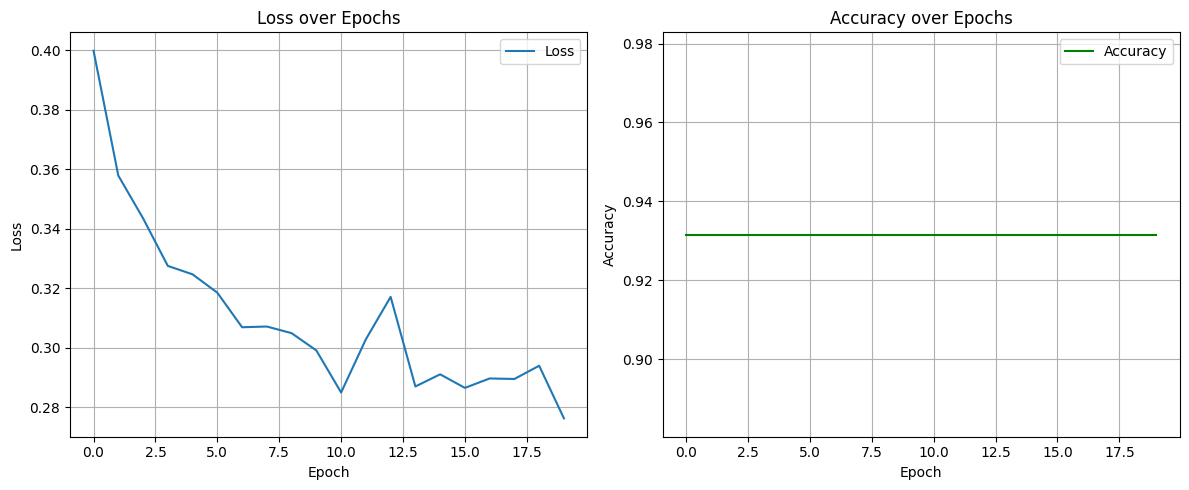

In [380]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Accuracy", color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [381]:
model_SECOM.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader_SECOM:
        X_batch = X_batch.to(model_SECOM.q_params.device)
        y_batch = y_batch.to(model_SECOM.q_params.device).unsqueeze(1)

        output = model_SECOM(X_batch)
        loss = loss_fn(output, y_batch)

        test_loss += loss.item() * X_batch.size(0)

        # Binary predictions
        preds = (output > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

avg_test_loss = test_loss / total
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2389, Test Accuracy: 0.9351


In [91]:
def evaluate_model_from_data(model, X, y_true, average='binary'):
    """
    Evaluates a trained model using the provided dataset.

    Parameters:
    - model: Trained model with .predict() method
    - X: Feature data
    - y_true: Ground truth labels
    - average: 'binary', 'macro', or 'weighted' (for multiclass)

    Returns:
    - Dictionary of evaluation metrics
    """

    X = torch.tensor(X).float()
    y_true = torch.tensor(y_true).float()

    # Predict labels
    try:
        y_pred = model(X)
    except Exception as e:
        return {"error": f"Model prediction failed: {e}"}

    # Predict probabilities if possible
    y_prob = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X)
            # For binary, use only positive class probs
            if y_prob.shape[1] == 2:
                y_prob = y_prob[:, 1]
        except:
            y_prob = None
    
    y_pred = y_pred.detach().numpy()
    y_pred = (y_pred > 0.5).astype(float)

    print("y_pred:", y_pred)

    # Metrics
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average=average, zero_division=0)
    metrics['Recall'] = recall_score(y_true, y_pred, average=average, zero_division=0)
    metrics['F1 Score'] = f1_score(y_true, y_pred, average=average, zero_division=0)
    metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred)
    metrics['Classification Report'] = classification_report(y_true, y_pred, zero_division=0)

    if y_prob is not None:
        try:
            if len(np.unique(y_true)) == 2:
                metrics['ROC AUC'] = roc_auc_score(y_true, y_prob)
            else:
                metrics['ROC AUC'] = roc_auc_score(y_true, y_prob, multi_class='ovr')
            metrics['Log Loss'] = log_loss(y_true, y_prob)
        except Exception as e:
            metrics['ROC AUC'] = f"Error: {e}"
            metrics['Log Loss'] = f"Error: {e}"

    return metrics
    # return y_pred, y_prob


In [320]:
y_pred__SECOM, y_prob__SECOM = evaluate_model_from_data(model_SECOM, X_SECOM_train, y_SECOM_train)

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_983/4139655915.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


In [321]:
y_pred__SECOM.shape

(1228, 1)

In [ ]:
y_pred__SECOM__proc = (y_pred__SECOM > 0.5)

In [329]:
# unique_items, counts = np.unique(y_pred__SECOM__proc, return_counts=True)
unique_items, counts = np.unique(y_SECOM_train, return_counts=True)

# Combine into a dictionary (optional)
item_counts = dict(zip(unique_items, counts))

print(item_counts)

{np.float64(0.0): np.int64(1144), np.float64(1.0): np.int64(84)}


In [ ]:
# Metrics
metrics = {}
metrics['Accuracy'] = accuracy_score(y_true, y_pred)
metrics['Precision'] = precision_score(y_true, y_pred, average=average, zero_division=0)
metrics['Recall'] = recall_score(y_true, y_pred, average=average, zero_division=0)
metrics['F1 Score'] = f1_score(y_true, y_pred, average=average, zero_division=0)
metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred)
metrics['Classification Report'] = classification_report(y_true, y_pred, zero_division=0)

if y_prob is not None:
    try:
        if len(np.unique(y_true)) == 2:
            metrics['ROC AUC'] = roc_auc_score(y_true, y_prob)
        else:
            metrics['ROC AUC'] = roc_auc_score(y_true, y_prob, multi_class='ovr')
        metrics['Log Loss'] = log_loss(y_true, y_prob)
    except Exception as e:
        metrics['ROC AUC'] = f"Error: {e}"
        metrics['Log Loss'] = f"Error: {e}"

In [649]:
count_0 = 0
for i in y_NSLKDD_train:
    if i == 0:
        count_0 += 1

print(count_0)
print(len(y_NSLKDD_train) - count_0)

5294
4706


Epoch 1, Loss: 0.6237, Accuracy: 0.6469
Epoch 2, Loss: 0.6227, Accuracy: 0.6510
Epoch 3, Loss: 0.6201, Accuracy: 0.6546
Epoch 4, Loss: 0.6202, Accuracy: 0.6534
Epoch 5, Loss: 0.6170, Accuracy: 0.6612
Epoch 6, Loss: 0.6234, Accuracy: 0.6547
Epoch 7, Loss: 0.6187, Accuracy: 0.6601
Epoch 8, Loss: 0.6225, Accuracy: 0.6505
Epoch 9, Loss: 0.6247, Accuracy: 0.6507
Epoch 10, Loss: 0.6133, Accuracy: 0.6622
Epoch 11, Loss: 0.6171, Accuracy: 0.6566
Epoch 12, Loss: 0.6160, Accuracy: 0.6565
Epoch 13, Loss: 0.6152, Accuracy: 0.6592
Epoch 14, Loss: 0.6182, Accuracy: 0.6534
Epoch 15, Loss: 0.6139, Accuracy: 0.6606
Epoch 16, Loss: 0.6162, Accuracy: 0.6611
Epoch 17, Loss: 0.6138, Accuracy: 0.6581
Epoch 18, Loss: 0.6198, Accuracy: 0.6596
Epoch 19, Loss: 0.6162, Accuracy: 0.6570
Epoch 20, Loss: 0.6198, Accuracy: 0.6529
Epoch 21, Loss: 0.6165, Accuracy: 0.6545
Epoch 22, Loss: 0.6180, Accuracy: 0.6554
Epoch 23, Loss: 0.6148, Accuracy: 0.6571
Epoch 24, Loss: 0.6158, Accuracy: 0.6614
Epoch 25, Loss: 0.6157, A

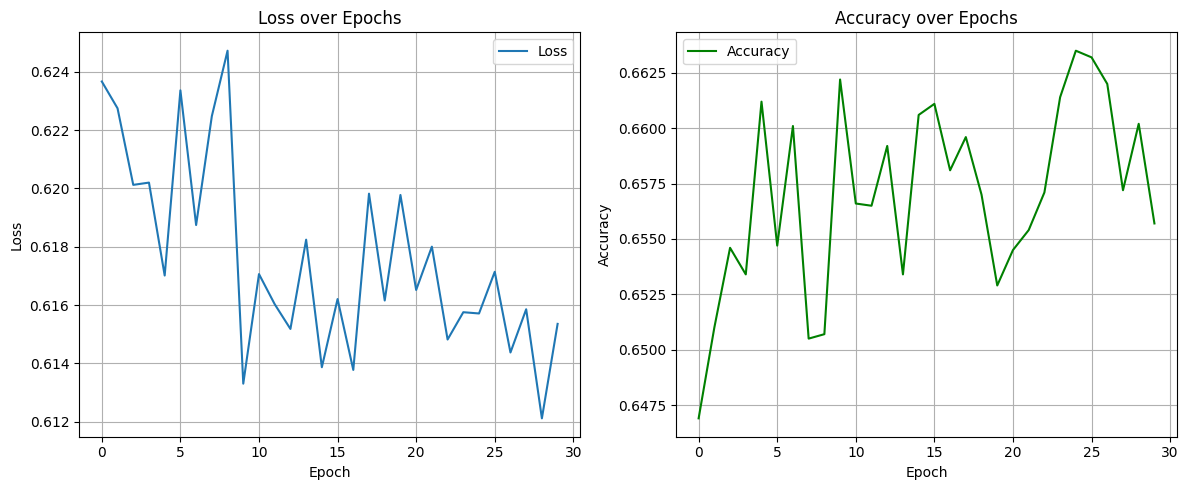

In [ ]:
epoch_losses = []
epoch_accuracies = []

for epoch in range(30):
    model_NSLKDD.train()
    total_correct = 0
    total_samples = 0
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader_NSLKDD:
        X_batch = X_batch.to(model_NSLKDD.q_params.device)
        y_batch = y_batch.to(model_NSLKDD.q_params.device).unsqueeze(1)

        optimizer.zero_grad()
        output = model_NSLKDD(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * X_batch.size(0)

        # Convert predictions to binary (assuming binary classification)
        preds = (output > 0.5).float()
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = epoch_loss / total_samples
    accuracy = total_correct / total_samples

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Accuracy", color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_NSLKDD.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader_NSLKDD:
        X_batch = X_batch.to(model_NSLKDD.q_params.device)
        y_batch = y_batch.to(model_NSLKDD.q_params.device).unsqueeze(1)

        output = model_NSLKDD(X_batch)
        loss = loss_fn(output, y_batch)

        test_loss += loss.item() * X_batch.size(0)

        # Binary predictions
        preds = (output > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

avg_test_loss = test_loss / total
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.6144, Test Accuracy: 0.7427


In [ ]:
y_SECOM_train

0       1
1       1
2       1
3       1
4       1
       ..
1248    1
1249    1
1250    1
1251    1
1252    1
Name: Pass/Fail, Length: 1253, dtype: int64

In [92]:
epoch_losses = []
epoch_accuracies = []

for epoch in range(30):
    model_SECOM.train()
    total_correct = 0
    total_samples = 0
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader_SECOM:
        # print(X_batch.min(), X_batch.max())
        # print(np.min(y_batch), np.max(y_batch))

        X_batch = X_batch.to(model_SECOM.q_params.device)
        y_batch = y_batch.to(model_SECOM.q_params.device).unsqueeze(1)

        optimizer.zero_grad()
        output = model_SECOM(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * X_batch.size(0)

        # Convert predictions to binary (assuming binary classification)
        preds = (output > 0.5).float()
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = epoch_loss / total_samples
    accuracy = total_correct / total_samples

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Accuracy", color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_983/4139655915.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


Epoch 1, Loss: 0.7243, Accuracy: 0.1458
Epoch 2, Loss: 0.7234, Accuracy: 0.1376
Epoch 3, Loss: 0.7232, Accuracy: 0.1311
Epoch 4, Loss: 0.7239, Accuracy: 0.1425
Epoch 5, Loss: 0.7232, Accuracy: 0.1458
Epoch 6, Loss: 0.7245, Accuracy: 0.1368


KeyboardInterrupt: 

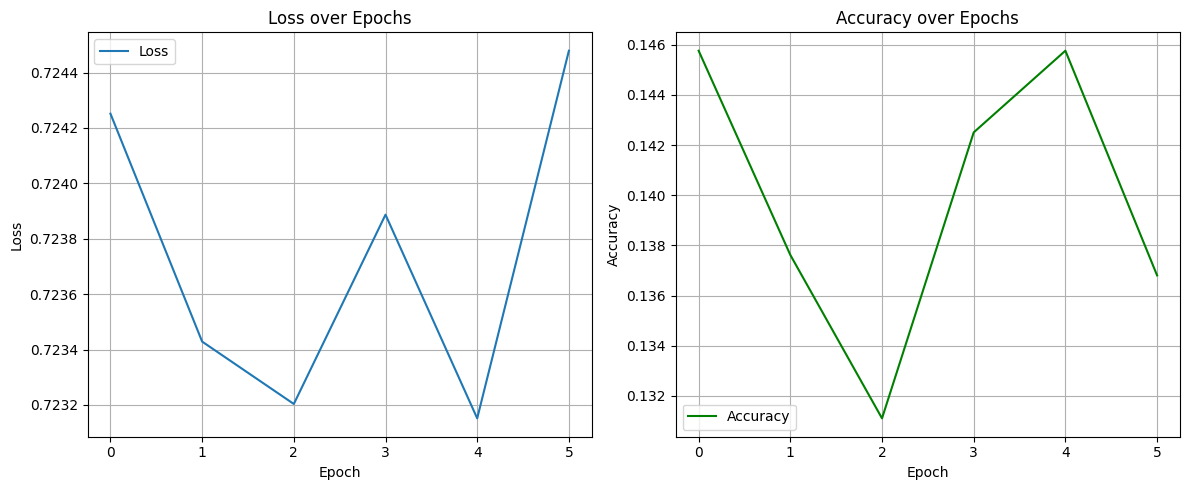

In [93]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Accuracy", color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
model_SECOM.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader_SECOM:
        X_batch = X_batch.to(model_SECOM.q_params.device)
        y_batch = y_batch.to(model_SECOM.q_params.device).unsqueeze(1)

        output = model_SECOM(X_batch)
        loss = loss_fn(output, y_batch)

        test_loss += loss.item() * X_batch.size(0)

        # Binary predictions
        preds = (output > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

avg_test_loss = test_loss / total
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_983/4139655915.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


Test Loss: 0.7189, Test Accuracy: 0.0649


# Optimization

## Quantum mid-circuit

In [63]:
def qiskit_mid_circuit(q_input_features, q_weights_flat, optimize, num_qubits=n_qubits):
    qiskit_mid_circ = QuantumCircuit(8)

    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    qiskit_mid_circ.h([_ for _ in range(num_qubits)])

    for idx, element in enumerate(q_input_features):
        qiskit_mid_circ.ry(element.item(), idx)
    
    for k in range(q_depth):
        for i in range(0, n_qubits - 1, 2):
            qiskit_mid_circ.cx(i, i + 1)
        for i in range(1, n_qubits - 1, 2):
            qiskit_mid_circ.cx(i, i + 1)
        
        for idx, element in enumerate(q_weights[k]):
            qiskit_mid_circ.ry(element.item(), idx)
    
    qiskit_mid_circ.measure_all()

    backend_sim = Aer.get_backend('qasm_simulator')
    estimator = Estimator(backend_sim)

    if optimize:
        cm = CouplingMap.from_line(num_qubits)
        backend = GenericBackendV2(num_qubits, coupling_map=cm)
        qc_routed = generate_preset_pass_manager(3, backend).run(qiskit_mid_circ)

    observables = [SparsePauliOp("I"*_ + "Z" + "I"*(num_qubits - _ - 1)) for _ in range(num_qubits)]

    theta = None
    expectations = []

    # job = estimator.run([qiskit_mid_circ], [observable])
    for observable in observables:
        if not optimize:
            job = estimator.run([(qiskit_mid_circ, observable)])
        else:
            job = estimator.run([(qc_routed, observable)])

        result = job.result()[0]
        
        expectations.append(result.data.evs)
    
    expectations = torch.tensor([float(x) for x in expectations])
    # print(expectations)

    if optimize:
        return expectations, qc_routed
    else:
        return expectations, qiskit_mid_circ

In [64]:
def get_qc_chars(qc):
   depth = qc.depth()
   num_qubits = qc.num_qubits
   ops = dict(qc.count_ops())
   num_multi_qubit_ops = qc.num_nonlocal_gates()

   return {"depth": depth, "num_qubits": num_qubits, "ops": ops, "num_multi_qubit_ops": num_multi_qubit_ops}

In [65]:
class DressedQuantumNet(nn.Module):
    """
    Torch module for the dressed quantum network.
    """
    def __init__(self, optimize, input_shape=51, dataset_idx=1):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.q_delta = 0.01
        self.optimize = optimize
        # self.pre_net = nn.Linear(input_shape, self.n_qubits)
        self.q_params = nn.Parameter(self.q_delta * torch.randn(self.q_depth * self.n_qubits))
        # self.post_net = nn.Linear(self.n_qubits, 7)

        if (dataset_idx == 1) or (dataset_idx == 2):
            self.pre_net = nn.Sequential(
                            nn.Linear(input_shape, 64),
                            nn.ReLU(),
                            nn.Linear(64, 64),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(64, 32),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(32, 16),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(16, 8)
                        )
        elif dataset_idx == 3:
            self.pre_net = nn.Sequential(
                            nn.Linear(input_shape, 16),
                            nn.ReLU(),
                            nn.Linear(16, 16),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(16, 8)
                        )

        self.post_net = nn.Sequential(
                            nn.Linear(n_qubits, 8),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(8, 4),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(4, 1)
                        )

    def forward(self, input_features):
        """
        Forward pass through the dressed quantum network.
        """
        # Preprocessing input to reduce dimensions
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply quantum circuit
        q_out = []
        for elem in q_in:
            elem = elem.clone().detach().to(self.q_params.device)  # Ensure it's on the correct device and detached
            # print("shape of elem before:", elem.shape)
            
            # q_out_elem = quantum_net(elem, self.q_params)  # Output as list
            q_out_elem, circuit = qiskit_mid_circuit(elem, self.q_params, self.optimize)
            # print("circuit params:", get_qc_chars(circuit))

            # print("parameters of the returned circuit:", get_qc_chars(circuit))
            # print("shape of q_out_elem:", q_out_elem)

            # Convert list to tensor if it's not already
            q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)

            # Apply linear transformation to match 2 output classes (if needed)
            # q_out_elem = torch.nn.Linear(q_out_elem_tensor.size(-1), 2)(q_out_elem_tensor)  # Adjust size to 2
            q_out_elem = self.post_net(q_out_elem_tensor)

            q_out.append(q_out_elem)

        # Stack and process
        q_out = torch.stack(q_out, dim=0)  # Ensure this is stacked correctly
        # print("q_out after loop:", q_out.shape)

        # q_out = q_out.to(self.q_params.device, dtype=torch.float32, requires_grad=True)

        return torch.sigmoid(q_out)

In [66]:
model_IEEE__opt = DressedQuantumNet(optimize=True, input_shape=50, dataset_idx=1)
model_NSLKDD__opt = DressedQuantumNet(optimize=True, input_shape=30, dataset_idx=2)
model_SECOM__opt = DressedQuantumNet(optimize=True, input_shape=10, dataset_idx=3)

## Training IEEE model with optimization

### same optimizer

In [67]:
i = 1
for X_batch, y_batch in train_loader_IEEE:
    print("shape:", X_batch.shape, y_batch.shape)
    i += 1

print(i)

shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: torch.Size([32, 50]) torch.Size([32])
shape: tor

In [68]:
import time

In [77]:
model_IEEE__opt = torch.load("/Users/soardr/VSCode Projects/Zenqor/Zenqor Drive/models/model training checkpoints/model_IEEE__classical_opt___0.pt", weights_only=False)

In [106]:
# optimizer = optim.Adam([p for n, p in model_IEEE__opt.named_parameters() if 'q_params' not in n], lr=0.001)
optimizer = optim.Adam(model_SECOM__opt.parameters(), lr=0.001)

# quantum_opt = optim.Adam([model_SECOM.q_params], lr=0.01)
# quantum_opt = QNGOptimizer(stepsize=0.01)

epoch_losses = []
epoch_accuracies = []
val_losses = []
val_accuracies = []
training_times = []

for epoch in range(20):
    model_SECOM__opt.train()
    total_correct = 0
    total_samples = 0
    epoch_loss = 0.0

    start_time = time.time()

    for X_batch, y_batch in train_loader_SECOM:
        # print(X_batch.min(), X_batch.max())
        # print(np.min(y_batch), np.max(y_batch))

        start_time_batch = time.time()

        X_batch = X_batch.to(model_SECOM__opt.q_params.device)
        y_batch = y_batch.to(model_SECOM__opt.q_params.device).unsqueeze(1)

        optimizer.zero_grad()
        output = model_SECOM__opt(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * X_batch.size(0)

        # Convert predictions to binary (assuming binary classification)
        preds = (output > 0.5).float()
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

        end_time_batch = time.time()
        print("time for one batch:", end_time_batch - start_time_batch)

    avg_loss = epoch_loss / total_samples
    accuracy = total_correct / total_samples

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)

    # Validation
    model_SECOM__opt.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in test_loader_SECOM:
            x, y = x.to(model_SECOM__opt.q_params.device), y.float().unsqueeze(1).to(model_SECOM__opt.q_params.device)
            outputs = model_SECOM__opt(x)
            loss = criterion(outputs, y)
            preds = (outputs > 0.5).float()
            val_acc += accuracy_score(y.cpu(), preds.cpu())
            val_loss += loss.item()
    
    # Store validation metrics
    avg_val_loss = val_loss / len(test_loader_SECOM)
    avg_val_acc = val_acc / len(test_loader_SECOM)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    epoch_time = time.time() - start_time
    training_times.append(epoch_time)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_loss:.4f} | "
          f"Train Acc: {accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {avg_val_acc:.4f} | "
          f"Time: {epoch_time:.2f}s")
    
    torch.save(model_IEEE__opt, F"/Users/soardr/VSCode Projects/Zenqor/Zenqor Drive/models/model training checkpoints/model_SECOM__classical_opt___{epoch}.pt")

    # print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Accuracy", color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 3.399364709854126
time for one batch: 2.8278820514678955
time for one batch: 2.747670888900757
time for one batch: 2.6004719734191895
time for one batch: 2.6037800312042236
time for one batch: 2.5382752418518066
time for one batch: 2.544771194458008
time for one batch: 2.586944103240967
time for one batch: 2.573607921600342
time for one batch: 3.09322190284729
time for one batch: 2.6606569290161133
time for one batch: 2.6814441680908203
time for one batch: 2.644138813018799
time for one batch: 3.8056252002716064
time for one batch: 2.975635051727295
time for one batch: 3.0203700065612793
time for one batch: 2.8144397735595703
time for one batch: 3.292827844619751
time for one batch: 3.2251970767974854
time for one batch: 2.8222291469573975
time for one batch: 3.119520902633667
time for one batch: 3.0888350009918213
time for one batch: 3.147550106048584
time for one batch: 2.8472650051116943
time for one batch: 2.891511917114258
time for one batch: 3.1721351146698
ti

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 1 | Train Loss: 0.5800 | Train Acc: 0.9316 | Val Loss: 0.5699 | Val Acc: 0.9319 | Time: 147.81s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 3.660946846008301
time for one batch: 4.229851961135864
time for one batch: 4.014008283615112
time for one batch: 3.8092846870422363
time for one batch: 3.758173942565918
time for one batch: 3.8372280597686768
time for one batch: 4.560691833496094
time for one batch: 4.347195863723755
time for one batch: 5.985796928405762
time for one batch: 6.165973901748657
time for one batch: 5.580487012863159
time for one batch: 5.358345985412598
time for one batch: 5.462794303894043
time for one batch: 5.2187769412994385
time for one batch: 5.122951030731201
time for one batch: 4.8656840324401855
time for one batch: 4.7006001472473145
time for one batch: 4.5555620193481445
time for one batch: 4.796100854873657
time for one batch: 4.313738822937012
time for one batch: 4.3263609409332275
time for one batch: 4.137035846710205
time for one batch: 4.054660797119141
time for one batch: 4.0272462368011475
time for one batch: 3.9643971920013428
time for one batch: 3.8819499015808105
ti

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 2 | Train Loss: 0.5510 | Train Acc: 0.9316 | Val Loss: 0.5374 | Val Acc: 0.9319 | Time: 203.35s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 3.9460232257843018
time for one batch: 4.101247072219849
time for one batch: 4.358296155929565
time for one batch: 4.353649139404297
time for one batch: 4.705444097518921
time for one batch: 4.247955799102783
time for one batch: 4.6373889446258545
time for one batch: 5.103206157684326
time for one batch: 4.525698900222778
time for one batch: 4.897731065750122
time for one batch: 4.859844207763672
time for one batch: 4.4473888874053955
time for one batch: 4.325330018997192
time for one batch: 4.813861131668091
time for one batch: 4.832674026489258
time for one batch: 4.8126540184021
time for one batch: 4.446469783782959
time for one batch: 4.940311908721924
time for one batch: 4.786549091339111
time for one batch: 5.119740009307861
time for one batch: 6.027637004852295
time for one batch: 5.366314888000488
time for one batch: 5.9371018409729
time for one batch: 6.769463062286377
time for one batch: 6.384149074554443
time for one batch: 5.174122095108032
time for one 

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 3 | Train Loss: 0.5178 | Train Acc: 0.9316 | Val Loss: 0.4944 | Val Acc: 0.9319 | Time: 249.54s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 5.589273929595947
time for one batch: 5.480302095413208
time for one batch: 5.963615894317627
time for one batch: 5.773761987686157
time for one batch: 5.509095191955566
time for one batch: 5.8608479499816895
time for one batch: 6.2885119915008545
time for one batch: 6.809600114822388
time for one batch: 6.3784708976745605
time for one batch: 5.857325792312622
time for one batch: 5.6736109256744385
time for one batch: 6.336374998092651
time for one batch: 7.095417022705078
time for one batch: 9.384573936462402
time for one batch: 8.055516719818115
time for one batch: 6.065000057220459
time for one batch: 6.086545944213867
time for one batch: 5.647055149078369
time for one batch: 6.410492181777954
time for one batch: 5.665489196777344
time for one batch: 6.328381061553955
time for one batch: 5.959480047225952
time for one batch: 6.459553956985474
time for one batch: 7.593086004257202
time for one batch: 7.680245637893677
time for one batch: 7.598801851272583
time for

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 4 | Train Loss: 0.4704 | Train Acc: 0.9316 | Val Loss: 0.4391 | Val Acc: 0.9319 | Time: 297.56s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 5.4136130809783936
time for one batch: 5.517298936843872
time for one batch: 5.168450117111206
time for one batch: 5.317502021789551
time for one batch: 5.778795003890991
time for one batch: 7.3292999267578125
time for one batch: 6.224058151245117
time for one batch: 5.899840831756592
time for one batch: 7.44815993309021
time for one batch: 8.095561027526855
time for one batch: 7.464474201202393
time for one batch: 7.196612119674683
time for one batch: 7.138476133346558
time for one batch: 6.489074945449829
time for one batch: 6.847343683242798
time for one batch: 7.134245872497559
time for one batch: 6.849777936935425
time for one batch: 6.42971396446228
time for one batch: 6.067496299743652
time for one batch: 6.63478684425354
time for one batch: 7.79686713218689
time for one batch: 7.672898054122925
time for one batch: 8.327607870101929
time for one batch: 8.42113995552063
time for one batch: 7.857454061508179
time for one batch: 8.732209920883179
time for one ba

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 5 | Train Loss: 0.4307 | Train Acc: 0.9316 | Val Loss: 0.3869 | Val Acc: 0.9319 | Time: 317.70s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 5.399285078048706
time for one batch: 5.2358078956604
time for one batch: 5.206154823303223
time for one batch: 5.044132947921753
time for one batch: 5.474442005157471
time for one batch: 5.23689079284668
time for one batch: 6.019412994384766
time for one batch: 5.1854002475738525
time for one batch: 5.081864833831787
time for one batch: 5.566030979156494
time for one batch: 5.18247127532959
time for one batch: 5.9011759757995605
time for one batch: 5.768842935562134
time for one batch: 5.322710037231445
time for one batch: 5.308898210525513
time for one batch: 5.746717929840088
time for one batch: 5.24708366394043
time for one batch: 5.349379062652588
time for one batch: 5.200327157974243
time for one batch: 5.172355890274048
time for one batch: 5.179336786270142
time for one batch: 5.179095029830933
time for one batch: 5.431904077529907
time for one batch: 5.264810085296631
time for one batch: 5.4622111320495605
time for one batch: 5.507246971130371
time for one b

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 6 | Train Loss: 0.4017 | Train Acc: 0.9316 | Val Loss: 0.3477 | Val Acc: 0.9319 | Time: 278.47s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 6.344864130020142
time for one batch: 6.018189191818237
time for one batch: 5.974591970443726
time for one batch: 5.87205696105957
time for one batch: 5.975389003753662
time for one batch: 5.873243093490601
time for one batch: 5.345375061035156
time for one batch: 6.2660768032073975
time for one batch: 6.262941837310791
time for one batch: 5.676732063293457
time for one batch: 6.55171799659729
time for one batch: 5.508084058761597
time for one batch: 5.499606132507324
time for one batch: 5.4217259883880615
time for one batch: 5.756028175354004
time for one batch: 5.451453924179077
time for one batch: 6.17203426361084
time for one batch: 5.863434076309204
time for one batch: 5.643002986907959
time for one batch: 6.246113061904907
time for one batch: 5.621070861816406
time for one batch: 5.666855812072754
time for one batch: 6.168460130691528
time for one batch: 5.553614854812622
time for one batch: 5.621326923370361
time for one batch: 6.293705940246582
time for one 

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 7 | Train Loss: 0.3733 | Train Acc: 0.9316 | Val Loss: 0.3188 | Val Acc: 0.9319 | Time: 287.14s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 6.146075010299683
time for one batch: 5.743194103240967
time for one batch: 5.808094024658203
time for one batch: 7.051425933837891
time for one batch: 7.258816957473755
time for one batch: 7.099299192428589
time for one batch: 6.987856864929199
time for one batch: 7.896987199783325
time for one batch: 7.5847907066345215
time for one batch: 6.259168863296509
time for one batch: 5.839007139205933
time for one batch: 6.081954002380371
time for one batch: 5.816819906234741
time for one batch: 5.865428924560547
time for one batch: 5.530951976776123
time for one batch: 5.62527322769165
time for one batch: 5.709055185317993
time for one batch: 5.368149042129517
time for one batch: 5.423566818237305
time for one batch: 5.144004821777344
time for one batch: 5.48921012878418
time for one batch: 5.244874000549316
time for one batch: 5.5626540184021
time for one batch: 5.5051891803741455
time for one batch: 5.669811964035034
time for one batch: 5.193235158920288
time for one b

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 8 | Train Loss: 0.3605 | Train Acc: 0.9316 | Val Loss: 0.3006 | Val Acc: 0.9319 | Time: 293.01s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 5.916100978851318
time for one batch: 6.224899053573608
time for one batch: 5.600791931152344
time for one batch: 6.353315830230713
time for one batch: 7.1188788414001465
time for one batch: 7.141458988189697
time for one batch: 6.709190130233765
time for one batch: 5.685877323150635
time for one batch: 5.646023988723755
time for one batch: 5.506572008132935
time for one batch: 5.818190813064575
time for one batch: 5.882664918899536
time for one batch: 5.853763103485107
time for one batch: 5.271015167236328
time for one batch: 5.25713586807251
time for one batch: 5.347290992736816
time for one batch: 5.037431716918945
time for one batch: 5.257628917694092
time for one batch: 5.167409896850586
time for one batch: 5.736783027648926
time for one batch: 5.598917007446289
time for one batch: 5.301928997039795
time for one batch: 6.294064044952393
time for one batch: 6.100923299789429
time for one batch: 5.7349629402160645
time for one batch: 6.178457975387573
time for on

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 9 | Train Loss: 0.3634 | Train Acc: 0.9316 | Val Loss: 0.2896 | Val Acc: 0.9319 | Time: 288.56s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 5.274921894073486
time for one batch: 5.705819845199585
time for one batch: 6.72119665145874
time for one batch: 5.729681730270386
time for one batch: 5.588896989822388
time for one batch: 5.446131944656372
time for one batch: 5.384458065032959
time for one batch: 6.002074718475342
time for one batch: 5.989470958709717
time for one batch: 5.744992017745972
time for one batch: 6.184553861618042
time for one batch: 7.512906074523926
time for one batch: 7.307141065597534
time for one batch: 6.560651779174805
time for one batch: 6.189805746078491
time for one batch: 6.485050916671753
time for one batch: 5.801167249679565
time for one batch: 5.668971061706543
time for one batch: 5.862579822540283
time for one batch: 5.733760118484497
time for one batch: 5.9358367919921875
time for one batch: 5.729434967041016
time for one batch: 6.256386756896973
time for one batch: 5.772143840789795
time for one batch: 5.503788948059082
time for one batch: 6.724637031555176
time for one

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 10 | Train Loss: 0.3490 | Train Acc: 0.9316 | Val Loss: 0.2741 | Val Acc: 0.9319 | Time: 336.49s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


time for one batch: 7.17434287071228
time for one batch: 7.031110048294067
time for one batch: 6.842531204223633
time for one batch: 6.9489710330963135
time for one batch: 6.351224184036255
time for one batch: 7.840710163116455
time for one batch: 7.123031139373779
time for one batch: 6.981737852096558
time for one batch: 6.915606737136841
time for one batch: 7.014419078826904
time for one batch: 6.67603611946106
time for one batch: 6.3568360805511475
time for one batch: 6.929815053939819
time for one batch: 6.472613096237183
time for one batch: 7.181267976760864
time for one batch: 6.644878149032593
time for one batch: 7.964337110519409
time for one batch: 6.726245880126953
time for one batch: 7.383046865463257
time for one batch: 6.86332106590271
time for one batch: 7.569169282913208
time for one batch: 7.660176038742065
time for one batch: 9.557176113128662
time for one batch: 9.921699047088623
time for one batch: 8.654752016067505
time for one batch: 7.96392297744751
time for one b

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 11 | Train Loss: 0.3449 | Train Acc: 0.9316 | Val Loss: 0.2638 | Val Acc: 0.9319 | Time: 371.60s


/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


KeyboardInterrupt: 

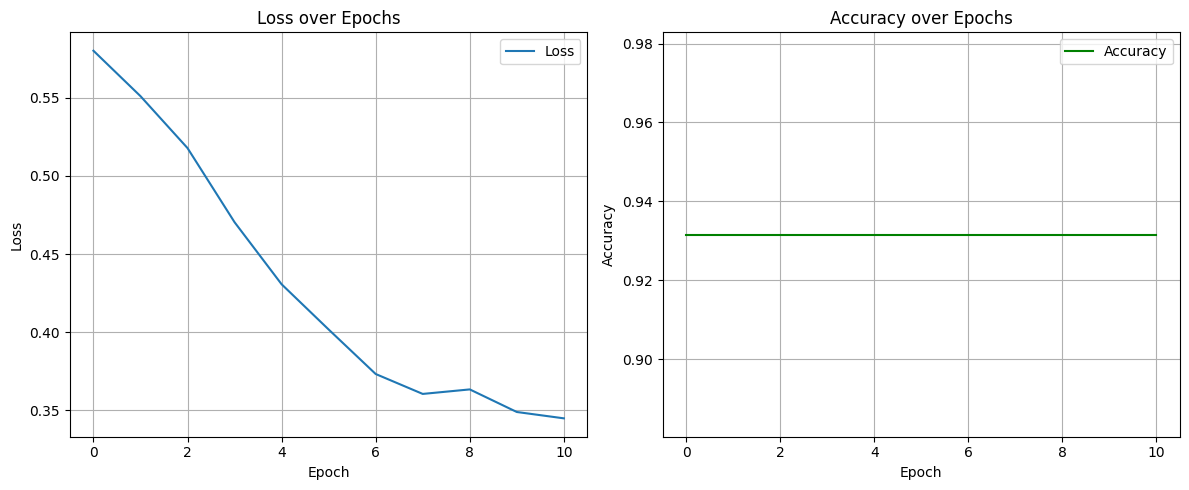

In [107]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Accuracy", color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

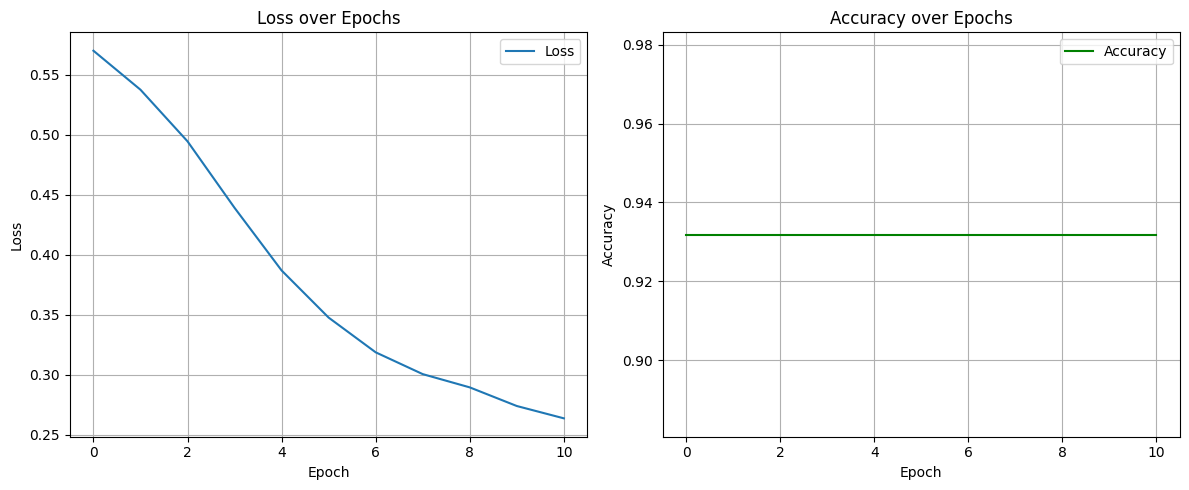

In [108]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(val_losses, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Accuracy", color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [102]:
epoch_losses

[0.7136,
 0.3376611474990845,
 0.250103878569603,
 0.22701480509638786,
 0.22552825813293456,
 0.2108788658618927,
 0.21568959500789642,
 0.21013618812561036]

In [100]:
epoch_accuracies

[0.3918, 0.8982, 0.9004, 0.907, 0.957, 0.9672, 0.9672, 0.9672]

In [103]:
val_losses

[0.4371,
 0.18273864378025578,
 0.15791432265263455,
 0.15733239052307074,
 0.1579440226244509,
 0.15784229070043107,
 0.15766386426747983,
 0.1575715471130268]

In [104]:
val_accuracies

[0.9634,
 0.9633757961783439,
 0.9633757961783439,
 0.9633757961783439,
 0.9633757961783439,
 0.9633757961783439,
 0.9633757961783439,
 0.9633757961783439]

In [105]:
training_times

[1546,
 1397.7836210727692,
 1683.857246875763,
 1419.8165969848633,
 1500.070672750473,
 1446.597953081131,
 1411.0368328094482,
 1490.9385647773743]

In [96]:
evaluate_model_from_data(model_IEEE__opt, X_IEEE_test[:], y_IEEE_test[:])

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


y_pred: [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


{'Accuracy': 0.965,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'Confusion Matrix': array([[4825,    0],
        [ 175,    0]]),
 'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.96      1.00      0.98      4825\n         1.0       0.00      0.00      0.00       175\n\n    accuracy                           0.96      5000\n   macro avg       0.48      0.50      0.49      5000\nweighted avg       0.93      0.96      0.95      5000\n'}

In [110]:
evaluate_model_from_data(model_SECOM__opt, X_SECOM_test[:], y_SECOM_test[:])

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_41005/2579699215.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem_tensor = torch.tensor(q_out_elem, dtype=torch.float32, device=self.q_params.device)


y_pred: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [

{'Accuracy': 0.935064935064935,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'Confusion Matrix': array([[288,   0],
        [ 20,   0]]),
 'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.94      1.00      0.97       288\n         1.0       0.00      0.00      0.00        20\n\n    accuracy                           0.94       308\n   macro avg       0.47      0.50      0.48       308\nweighted avg       0.87      0.94      0.90       308\n'}